<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment

What is model deployment ?  

Machine Learning model deployment is the act of macking your machine learning model(s) to someone else

* Book version of notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/

## 0. Get Setup

## 1. Getting Data

The dataset we're going to use for deploying FoodVision Mini model is ...

Pizza steak and sushi 20% dataset (pizza, steak, sushi classes from Food101, random20% of samples)




In [50]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [53]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is most ideal machine learning model deployment scenario ?
2. Where is my model going to go ?
3. How is my model going to function ?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) => 30 frames per seconds, the human eye can only see in between 30 to 60 fps  (30 FPS+ or 30ms latency)

To try an achive these goals, we are going to build two model experiments:
1. EffNetB2 feature extractor
2. ViT feature extractor




## 3. Creating a EffNetB2 feature extractor

Feature Extractor = a term for a transfer learning model that has it's base layers frozen and output layer (or head layers) customized to a certain problem.

EfficentNetB2 pretrained model in PyTorch - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2



In [54]:
## See issue with PyTorch - https://github.com/pytorch/vision/issues/7744#issuecomment-1757321451
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [55]:
 # 1. Setup pretrained model weights
effnetb2_weights = torchvision.models.efficientnet.EfficientNet_B2_Weights.DEFAULT

 # 2. Get the EffeNetB2 transforms
effnetb2_weight = effnetb2_weights.transforms()

 # 3. Load the pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

 # 4. Freeze the base layers in the model (this will stop all layers weight from training)
 for param in effnetb2.parameters():
    param.requires_grad = False

effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [56]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [57]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [58]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [59]:
### 3.1 Creating a function to create and EffnetB2 feature extractor
def create_effnetb2_model(
    num_classes:int=3,
    seed:int=42
):

  # 1. Setup pretrained model weights
  weights = torchvision.models.efficientnet.EfficientNet_B2_Weights.DEFAULT

  # 2. Get the EffeNetB2 transforms
  transforms = weights.transforms()

  # 3. Load the pretrained model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze the base layers in the model (this will stop all layers weight from training)
  for param in model.parameters():
      param.requires_grad = False

  # 5. Change the classifier head with random number for max reproducibility
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )

  return model, transforms

In [60]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model()

In [61]:
### 3.2 Creating dataloaders from dataset for effnetb2
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e4d4aa0b070>,
 ['pizza', 'steak', 'sushi'])

In [62]:
## 3.3 Training EffNetB2 feature extractor
from going_modular.going_modular import engine


# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr=1e-3)

# Train
set_seeds()
effnetb2_results = engine.train(
    model=effnetb2_model,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9663 | train_acc: 0.5854 | test_loss: 0.7382 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.6951 | train_acc: 0.8583 | test_loss: 0.5919 | test_acc: 0.9040
Epoch: 3 | train_loss: 0.5862 | train_acc: 0.8875 | test_loss: 0.4973 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4506 | train_acc: 0.9000 | test_loss: 0.4373 | test_acc: 0.9381
Epoch: 5 | train_loss: 0.4203 | train_acc: 0.9146 | test_loss: 0.4002 | test_acc: 0.9165
Epoch: 6 | train_loss: 0.4259 | train_acc: 0.8917 | test_loss: 0.3585 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.4287 | train_acc: 0.8625 | test_loss: 0.3319 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3891 | train_acc: 0.8917 | test_loss: 0.3494 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3750 | train_acc: 0.8875 | test_loss: 0.3164 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.3701 | train_acc: 0.8646 | test_loss: 0.2843 | test_acc: 0.9688


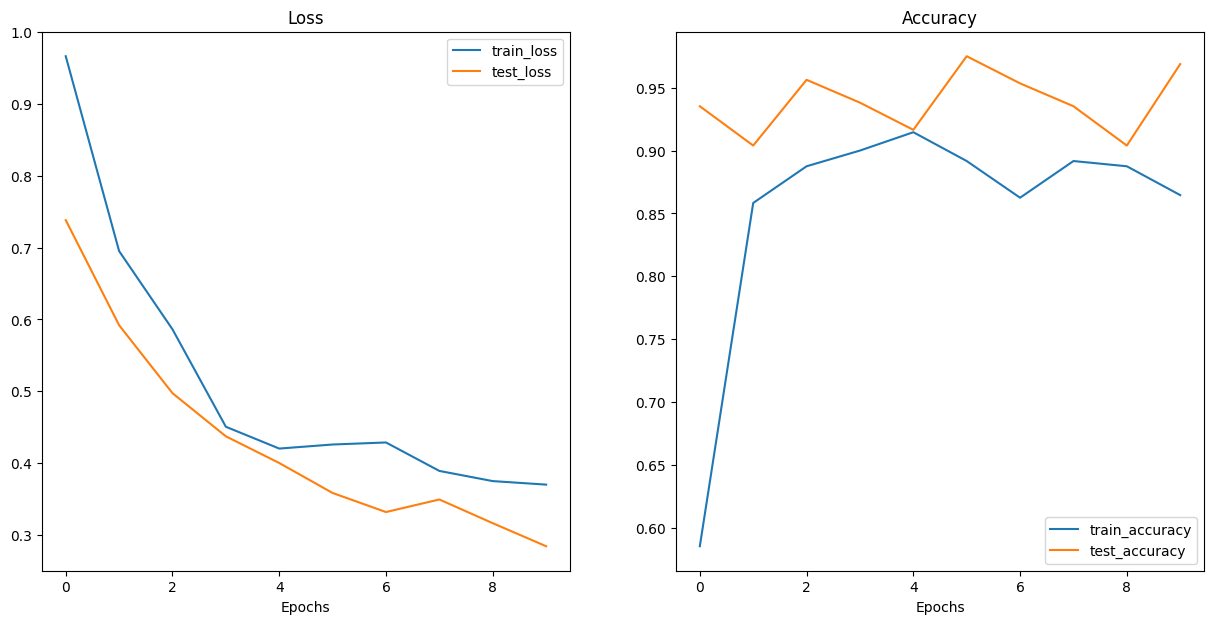

In [63]:
### 3.4 Inspecting Effnetb2 loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)


In [64]:
### 3.5 Saving EffnetB2 feature extractor
from going_modular.going_modular import utils

# Save model
utils.save_model(
    model=effnetb2_model,
    model_name="09_effnetb2_model_feature_extractor_pizza_steak_sushi_20_percent.pth",
    target_dir="models"
)

[INFO] Saving model to: models/09_effnetb2_model_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffnetB2 feature extractor

Why would it be import to consider the siz of a saved model ?

If we are going to deploy on mobile / web site there mabye limited computing resources.



In [65]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_effnetb2_model_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"EffnetB2 model size: {pretrained_effnetb2_model_size:.2f} MB")

EffnetB2 model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [66]:
# Count number of paramaters in EffNetB2
effnetb2_total_params = sum(p.numel() for p in effnetb2_model.parameters())
effnetb2_total_params


7705221

In [67]:
# Create a dictionary with EffNetB2 with Statistics

effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "train_loss": effnetb2_results["train_loss"][-1],
    "train_acc": effnetb2_results["test_acc"][-1],
    "number_of_paramaters": effnetb2_total_params,
    "model_size (MB)": pretrained_effnetb2_model_size
}

effnetb2_stats


{'test_loss': 0.28434053659439085,
 'test_acc': 0.96875,
 'train_loss': 0.37008601129055024,
 'train_acc': 0.96875,
 'number_of_paramaters': 7705221,
 'model_size (MB)': 29.8613224029541}

## 4. Creating a ViT feature extractor

In [68]:
# Checkout the ViT head layer
vit = torchvision.models.vit_b_16(weights="DEFAULT")
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [69]:
def create_vit_model(
    num_classes:int=3,
    seed:int=42
):

  # 1. Setup pretrained model weights
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  # 2. Get the ViT base transforms
  transforms = weights.transforms()

  # 3. Load the pretrained model
  model = torchvision.models.vit_b_16(weights=weights)

  # 4. Freeze the base layers in the model (this will stop all layers weight from training)
  for param in model.parameters():
      param.requires_grad = False

  # 5. Change the classifier head with random number for max reproducibility
  set_seeds(seed=seed)
  model.heads = torch.nn.Sequential(
      torch.nn.Linear(in_features=768, out_features=num_classes),
  )


  return model, transforms

In [70]:
vit, vit_transforms = create_vit_model(num_classes=3)
vit, vit_transforms

(VisionTransformer(
   (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
   (encoder): Encoder(
     (dropout): Dropout(p=0.0, inplace=False)
     (layers): Sequential(
       (encoder_layer_0): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (self_attention): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
         (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): MLPBlock(
           (0): Linear(in_features=768, out_features=3072, bias=True)
           (1): GELU(approximate='none')
           (2): Dropout(p=0.0, inplace=False)
           (3): Linear(in_features=3072, out_features=768, bias=True)
           (4): Dropout(p=0.0, inplace=False)
         )
       )
       (encoder_layer_1): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine

In [71]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create dataloaders for ViT feature extractor

In [72]:

from going_modular.going_modular import data_setup

vit_train_dataloader, vit_test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

len(vit_train_dataloader), len(vit_test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Train a ViT Feature Extractor

In [73]:
from going_modular.going_modular import engine


# Setup optimizer
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()


# Train ViT feature extractor
set_seeds()

vit_results = engine.train(
    model=vit,
    train_dataloader=vit_train_dataloader,
    test_dataloader=vit_test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

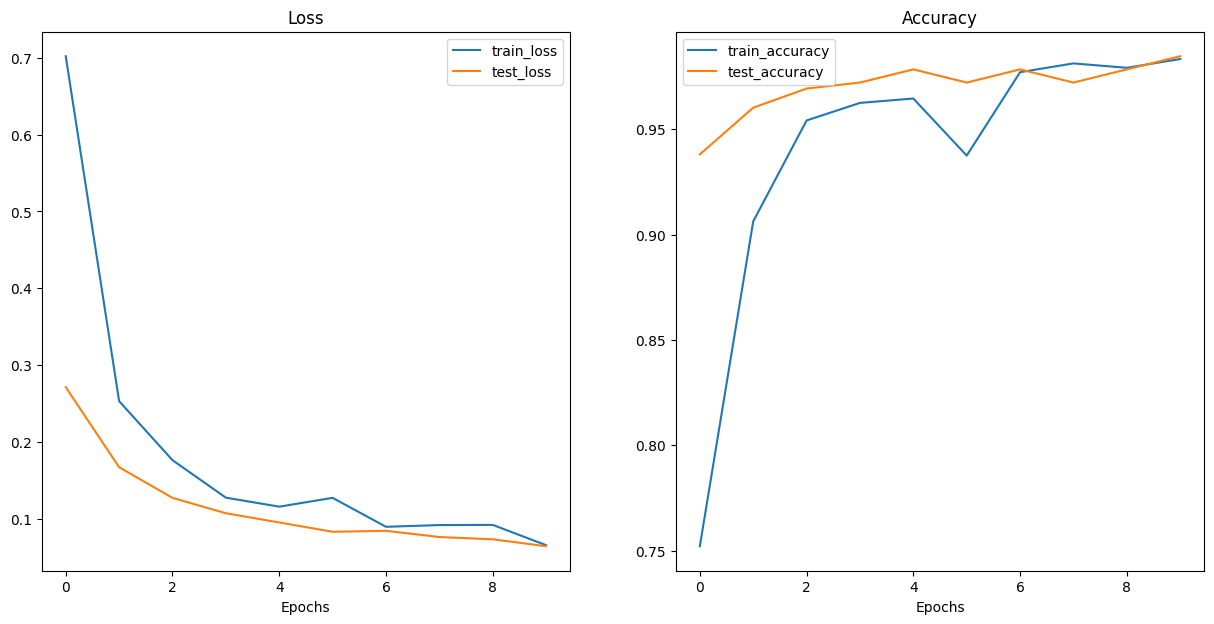

In [74]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)


### 4.4 Save of ViT feature extractor model

In [75]:
from going_modular.going_modular import utils

utils.save_model(
    model=vit,
    target_dir="models",
    model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")


[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [76]:
from pathlib import Path

pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size:.2f} MB")

Pretrained ViT model size: 327.37 MB


In [77]:
vit_total_params = sum(p.numel() for p in vit.parameters())
print(f"Total number of parameters: {vit_total_params}")

Total number of parameters: 85800963


### 4.6 Collecting ViT Feature Extractor Stats

In [78]:
vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "train_loss": vit_results["train_loss"][-1],
    "train_acc": vit_results["test_acc"][-1],
    "number_of_paramaters": vit_total_params,
    "model_size (MB)": pretrained_vit_model_size
}

vit_stats

{'test_loss': 0.06443453514948487,
 'test_acc': 0.984659090909091,
 'train_loss': 0.06576697633912167,
 'train_acc': 0.984659090909091,
 'number_of_paramaters': 85800963,
 'model_size (MB)': 327.37096977233887}

## 5. Making prediction with our trained models and timing

Our goal:
1. Perform well (95% test acc)
2. Fast (30+ FPS)

To test criteria two:
1. Loop trough images
2. Time how long it takes to do inference on these image


In [79]:
from pathlib import Path

# Get all data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903621.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/124279.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3886015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/389730.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg')]

### 5.1 Creating a function to make predicition across test dataset


In [80]:
import pathlib
import torch
import torchvision

from typing import List, Dict, Any
from timeit import default_timer as timer
from PIL import Image
from tqdm.auto import tqdm

def pred_and_store(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> List[Dict]:

  pred_list = []

  for path in tqdm(paths):
    pred_dict = {}

    pred_dict["image_path"] = path
    pred_dict["class_name"] = path.parent.stem

    start_time = timer()

    image = Image.open(path)
    transformed_image = transform(image).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # Turn logits into pred probability
      pred_label = torch.argmax(pred_prob, dim=1)  # Turn predicition probability into predicition label index
      pred_class = class_names[pred_label.cpu()]   # Turn pred label index into a predicition class

    pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
    pred_dict["pred_class"]= pred_class

    end_timer = timer()

    pred_dict["time_for_pred"] = round(end_timer - start_time, 4)

    pred_dict["correct"] = pred_dict["pred_class"] == pred_dict["class_name"]

    pred_list.append(pred_dict)

  return pred_list

### 5.2 Making and timing predicition with EffnetB2

1. Test our `pred_and_store()` function
2. We are going to hardcode that our prediction happen on CPU (We are not sure to have a GPU available)

In [81]:
effnetb2_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=effnetb2,
    transform=effnetb2_transforms,
    class_names=class_names,
    device="cpu"
)



  0%|          | 0/150 [00:00<?, ?it/s]

In [82]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903621.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4262,
  'pred_class': 'sushi',
  'time_for_pred': 0.1275,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/124279.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.3831,
  'pred_class': 'sushi',
  'time_for_pred': 0.0851,
  'correct': True}]

In [83]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()


,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.4262,sushi,0.1275,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.3831,sushi,0.0851,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.3722,pizza,0.0914,False
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.3750,pizza,0.0765,False
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.4244,pizza,0.0797,False


In [85]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

False    118
True      32
Name: correct, dtype: int64

In [86]:
# Find the average time per prediciton
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"Average time per prediciton: {effnetb2_average_time_per_pred} seconds")

Average time per prediciton: 0.0623 seconds


In [95]:
# Add time per pred

effnetb2_stats["time_per_pred"] = effnetb2_average_time_per_pred
effnetb2_stats


{'test_loss': 0.28434053659439085,
 'test_acc': 0.96875,
 'train_loss': 0.37008601129055024,
 'train_acc': 0.96875,
 'number_of_paramaters': 7705221,
 'model_size (MB)': 29.8613224029541,
 'time_per_pred': 0.0623}

**Note:** Predicition times will vary (much likes training time) base on the hardware you are using.


### 5.2 Making and timing predicition with ViT

1. Test our `pred_and_store()` function
2. We are going to hardcode that our prediction happen on CPU (We are not sure to have a GPU available)

In [89]:
vit_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device="cpu"
)


  0%|          | 0/150 [00:00<?, ?it/s]

In [90]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903621.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9072,
  'pred_class': 'sushi',
  'time_for_pred': 0.2005,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/124279.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.888,
  'pred_class': 'sushi',
  'time_for_pred': 0.1839,
  'correct': True}]

In [91]:
vit_pred_test_df = pd.DataFrame(vit_test_pred_dicts)
vit_pred_test_df.head()


,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9072,sushi,0.2005,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8880,sushi,0.1839,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9441,sushi,0.1898,True
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9910,sushi,0.1804,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6123,sushi,0.1973,True


In [93]:
# Check number of correct predictions
vit_pred_test_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [94]:
# Find the average time per prediciton
vit_average_time_per_pred = round(vit_pred_test_df.time_for_pred.mean(), 4)
print(f"Average time per prediciton: {vit_average_time_per_pred} seconds")

Average time per prediciton: 0.2043 seconds


In [96]:
vit_stats["time_per_pred"] = vit_average_time_per_pred
vit_stats


{'test_loss': 0.06443453514948487,
 'test_acc': 0.984659090909091,
 'train_loss': 0.06576697633912167,
 'train_acc': 0.984659090909091,
 'number_of_paramaters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred': 0.2043}

## 6. Comparing model results , prediction time and size

In [101]:
# Turn stat dict into DataFrame

df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentage
df["test_acc"] = round(df["test_acc"] * 100, 2)

# Convert time per pred to seconds
df["time_per_pred"] = df["time_per_pred"] / 1000

df




,test_loss,test_acc,train_loss,train_acc,number_of_paramaters,model_size (MB),time_per_pred,model
0,0.284341,96.88,0.370086,0.968750,7705221,29.861322,0.000062,EffNetB2
1,0.064435,98.47,0.065767,0.984659,85800963,327.370970,0.000204,ViT


Which model is better?
* `test_loss` lower is better - ViT
* `test_acc` lower is better - ViT
* `number_of_parameters`(generaly lower is better*) - EffNetB2 (if a model has more parameters, it generaly take longer to compute)
* `model_size(MB)` - EffNetB2
* `time_per_pred_cpu` (lower is better, highly dependent on hardward your are running on) - EffNetB2

Both our model failed to achive the 30 FPS


In [102]:
# Compare ViT to EffNetB2 accross different characteristics
pd.DataFrame(data = df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"],
             columns=["ViT to EffeNetB2 ratios"]).T

,test_loss,test_acc,train_loss,train_acc,number_of_paramaters,model_size (MB),time_per_pred
ViT to EffeNetB2 ratios,0.22661,1.016412,0.177707,1.016422,11.135432,10.963043,3.279294


### 6.1 Visualizing the speed vs. performance tradeoff

We've compared our EffNetB2 and ViT feature extractor, now let's compare them with a speed vs performance plot.

In [106]:
df = df.drop(columns=["train_loss", "train_acc"])

KeyError: ignored

In [107]:
df

,test_loss,test_acc,number_of_paramaters,model_size (MB),time_per_pred,model
0,0.284341,96.88,7705221,29.861322,0.000062,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.000204,ViT


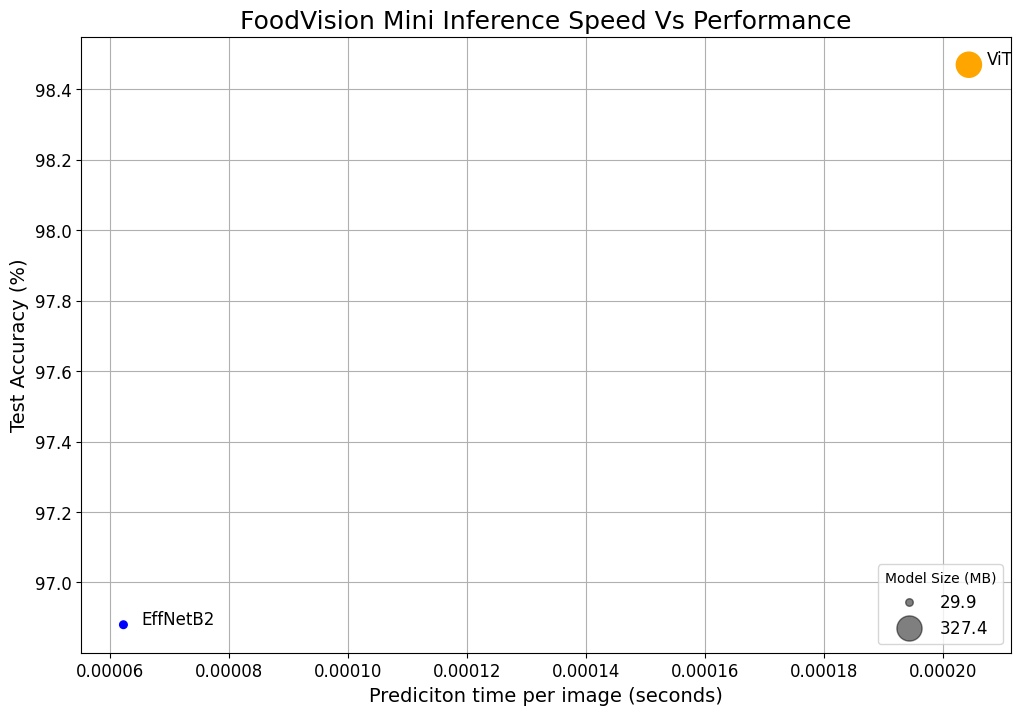

In [131]:
# 1. Create a plit from model comparaison dataframe
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    data=df,
    x="time_per_pred",
    y="test_acc",
    c=["blue", "orange"],
    s="model_size (MB)",
)

# 2. Add titles and labels
ax.set_title("FoodVision Mini Inference Speed Vs Performance", fontsize=18)
ax.set_xlabel("Prediciton time per image (seconds)", fontsize=14)
ax.set_ylabel("Test Accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot
for index, row in df.iterrows():
    ax.annotate(
        text=row["model"],
        xy=(row["time_per_pred"] + 0.000003, row["test_acc"]),
        size=12)

# 4. Create a legend based on the model size
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(
    handles,
    labels,
    loc="lower right",
    title="Model Size (MB)",
    fontsize=12
)

# Save the figure
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.png")
